<a href="https://colab.research.google.com/github/s07362022/CNN_to_train/blob/master/NN_self_hand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import os
import matplotlib.pyplot as plt
drive.mount('/content/drive')
project_path='/content/drive/MyDrive/'
os.chdir(project_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
def shuffle(x,y):
    x = x.T
    y = y.T
    combine = np.c_[x.reshape(len(x), -1), y.reshape(len(y), -1)]
    np.random.shuffle(combine)
    return combine[:, :x.size//len(x)].reshape(x.shape).T,combine[:, x.size//len(x):].reshape(y.shape).T
class One_layer:    
    def __init__(self, in_dim, out_dim, act,lr,apt_type,val):
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.weight = np.random.randn(out_dim,in_dim+1)/10
        
        #self.weight = np.random.rand(out_dim,in_dim+1)/10
        
        act_list = {"relu":self.sigmoid, "tanh":self.tanh,"relu":self.relu,"sigmoid":self.sigmoid,
                    "softmax":self.softmax,"linear":self.linear}
        dif_list = {"relu":self.dif_sigmoid, "tanh":self.dif_tanh,"relu":self.dif_relu,"sigmoid":self.dif_sigmoid,
                    "softmax":self.dif_softmax,"linear":self.dif_linear}
        self.act = act_list[act]
        self.dif_act = dif_list[act]
        self.lr = lr
        self.apt_type=apt_type
        if apt_type=='Momentum':
          self.Momentum = val
          self.weight_f = np.random.randn(out_dim,in_dim+1)/10
        elif apt_type=='AdaGrad':
          self.EPS = val
          self.weight_f = np.zeros([out_dim,in_dim+1])
        #self.batch_size = batch_size
        self.input = np.array([]) #np.zeros((batch_size,in_dim))
        self.local_grad = np.array([]) #np.zeros((batch_size,out_dim))    
        self.value = np.array([])
        
    def forward(self,data):    
        data = np.concatenate((np.ones(data.shape[1]).reshape(1,-1),data), axis=0)         
        self.input = data
        self.value = self.weight.dot(data)
        return self.act(self.value) 
    
    def output(self,data): 
        data = np.concatenate((np.ones(data.shape[1]).reshape(1,-1),data), axis=0) 
        return self.act(self.weight.dot(data))    
    
    def backward(self,err):
        self.local_grad = self.dif_act(self.value,err)
        return self.weight.T.dot(self.local_grad)[1:,:]    
    
    def weight_renew(self,batch_size):       
        delta_w = self.lr*(self.local_grad).dot(self.input.T)#/batch_size#
        if self.apt_type=='None':
          self.weight = self.weight - delta_w
        elif self.apt_type=='Momentum':
          #self.weight = self.weight - delta_w + (self.Momentum * self.weight_f)
          self.weight = self.weight + self.weight_f
          #self.weight_f = (self.local_grad).dot(self.input.T)
          self.weight_f = self.Momentum * self.weight_f - delta_w
        elif self.apt_type=='AdaGrad':
          self.weight = self.weight - delta_w * (1/np.sqrt(self.weight_f+self.EPS))
          self.weight_f = self.weight_f + ((self.local_grad).dot(self.input.T))**2
        return self.weight    
    def sigmoid(self,z):
        return 1/(1+np.exp(-z))
    def tanh(self,z):
        return (np.exp(z)-np.exp(-z))/(np.exp(z)+np.exp(-z))
    def relu(self,z):
        return np.maximum(0,z)  
    
    def linear(self,z):
        return z 
    
    def dif_linear(self,z,err):
        return err
    
    def softmax(self,x):
        shiftx = x - np.max(x)
        exps = np.exp(shiftx)
        return exps / np.sum(exps,axis=0)    
    
    def dif_sigmoid(self,z,err):
        temp=self.sigmoid(z)        
        return (temp*(1-temp))*err    
    def dif_tanh(self,z,err):
        return (1-self.tanh(self,z)**2)*err    
    def dif_relu(self,z,err):
        return np.maximum(np.sign(z),0)*err     
    def dif_softmax(self,z,err):
        local_grad = []
        for i,ee in enumerate(z.T):
            ee = ee.T.reshape(1,-1)
            tt = self.softmax(ee.T)
            local_grad.append((np.eye(ee.size)*tt-tt.dot(tt.T)).dot(err[:,i]))
        return np.array(local_grad).T#(np.eye(self.out_dim)*S - S.dot(S.T)).dot(err)
    def fetch_w(self):
        return self.weight

class RBF_layer:    
    def __init__(self, in_dim, out_dim, cent_lr, wid_lr,data,act="gaussian"):
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.centers = self.plus_plus(data, out_dim)
        self.var_sqr_inv = np.ones((out_dim,in_dim))/10
        
        act_list = {"gaussian":self.gaussian, "inv_quadratic":self.quadratic}
        act_diff_list = {"gaussian":self.diff_gaussian, "inv_quadratic":self.diff_quadratic}
        
        self.act = act_list[act]
        self.act_diff = act_diff_list[act]
        
        self.cent_lr = cent_lr
        self.wid_lr = wid_lr
        self.output_norm1 = []
        self.out = []
        self.err_diff = []
    def gaussian(self,data):
        return np.exp(-data)
    def quadratic(self,data):
        return 1/(1+data)**0.5
    
    def forward(self,data): 
        o1 = []
        for i,cc in enumerate(self.centers):
            o1.append((data.T-cc))            
        self.output_norm1 = np.array(o1) 
        
        ot = []          
        for i,dc in enumerate(np.array(o1)):
            ot.append((dc**2).dot(self.var_sqr_inv[i].reshape(-1,1))[:,0])        
        temp =  self.act(np.array(ot))
        self.out = temp
        return temp    
    def output(self,data): 
        o1 = []
        for i,cc in enumerate(self.centers):
            o1.append((data.T-cc))             
        ot = []           
        for i,dc in enumerate(np.array(o1)):
            ot.append((dc**2).dot(self.var_sqr_inv[i].reshape(-1,1))[:,0])  
        temp =  self.act(np.array(ot))
        #self.out = temp
        return temp  
    
    def backward(self,err):
        self.err_diff = err
        return 0 
    
    def weight_renew(self,batch_size):   
        self.act_diff()
    
    def diff_quadratic(self):
        delta_c = []
        for i,dc in enumerate(self.output_norm1):
            delta_c.append(-(2*dc.T*self.var_sqr_inv[i].reshape(-1,1)).dot((self.err_diff[i]*-0.5*self.out[i]**3).reshape(-1,1))[:,0])
        delta_c = np.array(delta_c)
        
        delta_wid = []
        for i,dc in enumerate(self.output_norm1):
            delta_wid.append((self.err_diff[i]*-0.5*self.out[i]**3).dot(dc**2))
        delta_wid = np.array(delta_wid)
        
        self.centers -= self.cent_lr*delta_c
        self.var_sqr_inv = np.maximum(0,self.var_sqr_inv- self.wid_lr*delta_wid) 
        
    def diff_gaussian(self):
        delta_c = []
        for i,dc in enumerate(self.output_norm1):
            delta_c.append((2*dc.T*self.var_sqr_inv[i].reshape(-1,1)).dot((self.err_diff[i]*self.out[i]).reshape(-1,1))[:,0])
        delta_c = np.array(delta_c)
        
        delta_wid = []
        for i,dc in enumerate(self.output_norm1):
            delta_wid.append(-(self.err_diff[i]*self.out[i]).dot(dc**2))
        delta_wid = np.array(delta_wid)
        
        self.centers -= self.cent_lr*delta_c
        self.var_sqr_inv = np.maximum(0,self.var_sqr_inv- self.wid_lr*delta_wid) 
        
    def plus_plus(self,ds, k):
        centroids = [ds[0]]
        for _ in range(1, k):
            dist_sq = np.array([min([np.inner(c-x,c-x) for c in centroids]) for x in ds])
            probs = dist_sq/dist_sq.sum()
            cumulative_probs = probs.cumsum()
            r = np.random.rand()
            for j, p in enumerate(cumulative_probs):
                if r < p:
                    i = j
                    break
            centroids.append(ds[i])
        return np.array(centroids)

class NN_model:
    def __init__(self,layer_list,batch_size,loss):
        cost_list = {"Binary":self.CE_twoclass, "Multi_class":self.CE,
                     "Regression_mse":self.MSE,"Regression_mae":self.MAE}     
        cost_dif_list = {"Binary":self.dif_ce_twoclass, "Multi_class":self.dif_ce,
                         "Regression_mse":self.dif_mse,"Regression_mae":self.dif_mae}
        self.layer_list = layer_list
        self.batch_size = batch_size
        self.loss=cost_list[loss]
        self.dif_loss=cost_dif_list[loss]
        
        acc_type_list = {"Binary":self.acc_binary, "Multi_class":self.acc_multiclass
                         ,"Regression_mae":self.acc_regression,"Regression_mse":self.acc_regression}
        self.loss_func = acc_type_list[loss]
        
    def output(self,x):
        temp = x
        for ll in self.layer_list:
            temp = ll.output(temp)
        return temp
    
    def forward(self,x):
        temp = x
        for ll in self.layer_list:
            temp = ll.forward(temp)            
        return temp
    
    def back_propagation(self,x):
        temp = x
        for ll in self.layer_list[::-1]:
            temp = ll.backward(temp)
        return temp
    
    def loss_dif(self,y,y_hat):  
        return self.dif_loss(y,y_hat)    
    
    def MSE(self,y,y_hat,scale):
        err_avg = np.sum(((y_hat-y)*scale[1])**2,axis=0)
        return err_avg,sum(err_avg)/y_hat.shape[1]
    
    def MAE(self,y,y_hat,scale):
        err_avg = np.sum(np.abs((y_hat-y)*scale[1]),axis=0)
        return err_avg,sum(err_avg)/y_hat.shape[1]
    
    def CE_twoclass(self,p,y):
        err = -(y*np.log(p)+(1-y)*np.log(1-p))
        each_batch_avg_err = np.sum(err,axis=1)/err.shape[1]
        total_avg_err = sum(each_batch_avg_err)
        return err,total_avg_err
    
    def CE(self,p,y):
        err = -np.log(np.sum(p*y,axis=0))
        return err,sum(err)/p.shape[1]
    
    def dif_ce_twoclass(self,p,y):            
        #return (np.sum(-(np.divide(y, p) - np.divide(1 - y, 1 - p)),axis=1)/y.shape[1]).reshape(-1,1) 
        return (-(np.divide(y, p) - np.divide(1 - y, 1 - p)))
    
    def dif_ce(self,p,y):
        return -np.divide(1,p)*y 
    
    def dif_mae(self,y,y_hat):
        #return -(np.sum(y_hat-y,axis=1)/y.shape[1]).reshape(-1,1)
        return -np.sign((y_hat-y))
    
    def dif_mse(self,y,y_hat):
        #return -(np.sum(y_hat-y,axis=1)/y.shape[1]).reshape(-1,1)
        return -(y_hat-y)
    
    def update_weight(self):
        for ll in self.layer_list:
            ll.weight_renew(self.batch_size)
        return self.layer_list[len(self.layer_list)-1].weight
    def shuffle(self,x,y):
        x = x.T
        y = y.T
        combine = np.c_[x.reshape(len(x), -1), y.reshape(len(y), -1)]
        np.random.shuffle(combine)
        return combine[:, :x.size//len(x)].reshape(x.shape).T,combine[:, x.size//len(x):].reshape(y.shape).T
    
    # -------------------------------------- Acc --------------------------------------------------#
    def acc_binary(self,ee,epochs,x_train,x_valid,y_train,y_valid,scale=[]):
        y_va = self.output(x_valid)
        vl = self.loss(y_va,y_valid)[1]
        y_tr = self.output(x_train)
        tl = self.loss(y_tr,y_train)[1]        
        ta = self.bb_acc(y_tr,y_train)
        va = self.bb_acc(y_va,y_valid)        
        print("Epoch",ee,"/",epochs,"- loss: %.4f" %tl,
            "- accuracy: %.4f" %ta,
            "- val_loss: %.4f" %vl,
            "- val_accuracy: %.4f" %va)            
        return [tl,vl,ta,va]
    
        out =(yhat> 0.5).astype(int)
        return np.sum(np.equal(y.reshape(-1,1),out.reshape(-1,1)))/y.size
    
    def bb_acc(self,yhat,y):
        out =(yhat> 0.5).astype(int)
        return np.sum(np.equal(y.reshape(-1,1),out.reshape(-1,1)))/y.size
    
    def acc_multiclass(self,ee,epochs,x_train,x_valid,y_train,y_valid,scale=[]):
        y_va = self.output(x_valid)
        vl = self.loss(y_va,y_valid)[1]
        y_tr = self.output(x_train)
        tl = self.loss(y_tr,y_train)[1]         
        ta = self.mc_acc(y_tr,y_train)
        va = self.mc_acc(y_va,y_valid)        
        print("Epoch",ee,"/",epochs,"- loss: %.4f" %tl,
            "- accuracy: %.4f" %ta,
            "- val_loss: %.4f" %vl,
            "- val_accuracy: %.4f" %va)            
        return [tl,vl,ta,va]
    
    def mc_acc(self,yhat,y):
        y_hat = np.argmax(yhat,axis=0)
        yy = np.argmax(y,axis=0)
        return np.sum(np.equal(y_hat,yy))/len(yy)
    
    def acc_regression(self,ee,epochs,x_train,x_valid,y_train,y_valid,scale):
        y_va = self.output(x_valid)
        vl = self.loss(y_va,y_valid,scale)[1]
        y_tr = self.output(x_train)
        tl = self.loss(y_tr,y_train,scale)[1] 
        print("Epoch",ee,"/",epochs,"- loss: %.4f" %tl,
              "- val_loss: %.2f " %vl) 
        return [tl,vl]
    
    def training(self,x_train,x_valid,y_train,y_valid,epochs,scale=[]):        
        batches = int(x_train.shape[1]/self.batch_size)
        max_index = x_train.shape[1]    
        history = []
        w_list = []
        for ee in range(epochs):
            x_train,y_train = self.shuffle(x_train,y_train) ## 每次training data 的順序打亂
            for batch in range(batches):
                st = batch*self.batch_size
                end = min((st+self.batch_size),max_index)                  
                out = self.forward(x_train[:,st:end])
                err = self.loss_dif(out,y_train[:,st:end])
                self.back_propagation(err)
                w_list.append(self.update_weight())                
            history.append(self.loss_func(ee,epochs,x_train,x_valid,y_train,y_valid,scale))
        return np.array(history),w_list



In [3]:
import pandas as pd
import numpy as np
import os


class DataLoader:
    def __init__(self, file_path=None):
        self.__file_df = None

        if file_path is not None:
            try:
                self.load_csv_file(file_path)
            except Exception as e:
                print(e)

    def load_csv_file(self, file_path):
        self.__file_df = pd.read_csv(file_path, )
        print("load_csv_file:ok")

    def process_data(self, normalize='max', label='probability', validation_rate=0.2, balance='mix'):
        """
        data processing
        :param normalize:   'mean': (x-u)/std;
                            'min_max': (x-min)/(max-min);
                            'max': x/max;
                            None: do not execute normalize;
        :param label:   'binary': shape(1, #), 0: N, 1: Y;
                        'probability': shape(2, #);
        :param validation_rate: rate of validation data
        :param balance:     'over_sample': copy minor data twice
                            'down_sample': remove major data until the amount of major data is as same as minor data,
                            'mix': mix the above methods
                            None: do not execute balance;
        """
        __data = None
        __label = None

        if self.__file_df is not None:
            # try:
                # delete 'duration'
                #self.__file_df=self.__file_df.drop(columns=['duration'])

                # process 'pdays' data
                #self.__file_df['pdays']=(self.__file_df['pdays']!=999).astype(int)

                # Process data
                #print(df.columns.values)
                print(self.__file_df)
                
                for col in self.__file_df.columns.values:
                    #print(col)
                    
                    # Separate label from data
                    if col == 'Drug':
                        #print("OK2")
                        #__label = self.__file_df[col].replace(to_replace=['drugA','drugB','drugC','drugX','DrugY'], value=[0,1,2,3,4])
                        if label == 'binary':
                            __label = self.__file_df[col].replace(to_replace=['drugA','drugB','drugC','drugX','DrugY'], value=[0,1,2,3,4])#.map({'drugA':0,'drugB':1,'drugC':2,'drugX':3,'DrugY':4})
                            #one_hot = pd.get_dummies(__label)
                            print("__label:OK2")

                        elif label == 'probability':
                            __label = pd.get_dummies(self.__file_df[col])
                            __category = __label.columns.values
                        else:
                            # raise print('[ERROR] process_data: error input in label')
                            raise Exception(label)
                        self.__file_df = self.__file_df.drop(col, axis=1)

                    # Process category attribute
                    elif self.__file_df[col].dtype == 'object':
                        # one-hot encoding
                        one_hot = pd.get_dummies(self.__file_df[col], prefix=col)
                        self.__file_df = self.__file_df.drop(col, axis=1)
                        self.__file_df = self.__file_df.join(one_hot)
                        print("onehot")
                    # Process numerical attribute
                    else:
                        self.__file_df[col] = self.normalize(self.__file_df[col], normalize)

                __data = self.__file_df.to_numpy()
                __label = __label.to_numpy()

                # Split data
                train_data, train_label, valid_data, valid_label = self.split_data(__data, __label, validation_rate=validation_rate)

                # Balance data 如果要使用請擇一使用 !!!!!!!!!!!!!!!!!!!!!!!!! !!!!!!!!!!!!!!!!!!!!
                train_data, train_label = self.balance_data(train_data, train_label, balance)

                return train_data, train_label, valid_data, valid_label
            # except Exception as e:
            #     print(e)
        else:
            print('[ERROR] No file loaded')

    @staticmethod
    def normalize(col, normalize_type):
        if normalize_type == 'max':
            return col / col.max()
        elif normalize_type == 'mean':
            return (col - col.mean()) / col.std()
        elif normalize_type == 'min_max':
            return (col - col.min()) / (col.max() - col.min())
        else:
            return col

    @staticmethod
    def split_data(data, label, validation_rate):
        #print(len(label.shape))
        if len(label.shape) == 1:
            no_indices = np.where(label == 0)[0]
            yes_indices = np.where(label == 1)[0]
            b =  np.where(label == 2)[0]
            c = np.where(label == 3)[0]
            d = np.where(label == 4)[0]
            #print(d)類別需要改
        else:
            no_indices = np.where(label[:, 0] == 1)[0]
            yes_indices = np.where(label[:, 1] == 1)[0]
            b = np.where(label[:, 2] == 1)[0]
            c = np.where(label[:, 3] == 1)[0]
            d = np.where(label[:, 4] == 1)[0]
            print(len(no_indices),len(yes_indices),len(b),len(c),len(d))
            #print("ok4:",b) 類別需要改

        no_indices = np.random.permutation(no_indices)
        yes_indices = np.random.permutation(yes_indices)
        b = np.random.permutation(b)
        c = np.random.permutation(c)
        d = np.random.permutation(d)

        valid_indices = np.concatenate((no_indices[:int(len(no_indices) * validation_rate)],
                                        yes_indices[:int(len(yes_indices) * validation_rate)],b[:int(len(b) * validation_rate)],c[:int(len(c) * validation_rate)],d[:int(len(d) * validation_rate)]), axis=0)

        train_indices = np.concatenate((no_indices[int(len(no_indices) * validation_rate):],
                                        yes_indices[int(len(yes_indices) * validation_rate):],b[int(len(b) * validation_rate):],c[int(len(c) * validation_rate):],d[int(len(d) * validation_rate):]), axis=0)

        train_indices = np.random.permutation(train_indices)
        valid_indices = np.random.permutation(valid_indices)

        train_data = data[train_indices]
        valid_data = data[valid_indices]

        if len(label.shape) == 1:
            train_label = label[train_indices, np.newaxis]
            valid_label = label[valid_indices, np.newaxis]
        else:
            train_label = label[train_indices]
            valid_label = label[valid_indices]

        return train_data, train_label, valid_data, valid_label

    @staticmethod
    #######第一個增加原始資料量比較少的資料,使其各個資料量相差不多!!!!!!!!!!!!!!!!
    ######第二個降低原始資料量比較多的資料,使其各個資料量相差不多###########
    def balance_data(data, label, method):
        if method is not None:
            if label.shape[1] == 1: # for binary label
                no_indices = np.where(label[:, 0] == 0)[0]
                yes_indices = np.where(label[:, 0] == 1)[0]
                print("labe=1")
                
            else: # for probability label
                no_indices = np.where(label[:, 0] == 1)[0]
                yes_indices = np.where(label[:, 1] == 1)[0]
                b = np.where(label[:, 2] == 1)[0]
                c = np.where(label[:, 3] == 1)[0]
                d = np.where(label[:, 4] == 1)[0]
                #print("labe!=1")
                #print(len(no_indices),len(yes_indices),len(b),len(c),len(d))

            if method == 'over_sample' or method == 'mix':
                if len(d) > len(yes_indices):
                    yes_indices = np.concatenate((yes_indices, yes_indices), axis=0)
                    yes_indices = np.concatenate((yes_indices, yes_indices), axis=0)
                    b = np.concatenate((b, b), axis=0)
                    b = np.concatenate((b, b), axis=0)
                    c = np.concatenate((c, c), axis=0)
                    c = np.concatenate((c, c), axis=0)

                    #print("YES")
                #else:
                    #d = np.concatenate((d, d), axis=0)
            #if method == 'down_sample' or method == 'mix':
                #if len(no_indices) > len(yes_indices):
                
                    #no_indices = no_indices[: len(yes_indices)]
                    #d = d[: len(yes_indices)]
                    #print("len(no_indices)",len(no_indices))
                    
                #else:
                    #yes_indices = yes_indices[: len(d)]

            indices = np.concatenate((d, yes_indices,c,no_indices,b), axis=0)
            indices = np.random.permutation(indices)
            print(len(no_indices),len(yes_indices),len(b),len(c),len(d))

            data = data[indices]
            label = label[indices]

        return data, label


In [4]:
# from data_loader import DataLoader

dl = DataLoader(project_path+"drug200.csv")
train_data, train_label, valid_data, valid_label = dl.process_data(label='probability', balance='mix')
train_data=train_data.T
valid_data=valid_data.T
train_label=train_label.T
valid_label=valid_label.T
print(train_data.shape)
print(train_label.shape)
print(valid_data.shape)
print(valid_label.shape)

load_csv_file:ok
     Age Sex      BP Cholesterol  Na_to_K   Drug
0     23   F    HIGH        HIGH   25.355  DrugY
1     47   M     LOW        HIGH   13.093  drugC
2     47   M     LOW        HIGH   10.114  drugC
3     28   F  NORMAL        HIGH    7.798  drugX
4     61   F     LOW        HIGH   18.043  DrugY
..   ...  ..     ...         ...      ...    ...
195   56   F     LOW        HIGH   11.567  drugC
196   16   M     LOW        HIGH   12.006  drugC
197   52   M  NORMAL        HIGH    9.894  drugX
198   23   M  NORMAL      NORMAL   14.020  drugX
199   40   F     LOW      NORMAL   11.349  drugX

[200 rows x 6 columns]
onehot
onehot
onehot
91 23 16 16 54
73 76 52 52 44
(9, 297)
(5, 297)
(9, 38)
(5, 38)


In [201]:
train_label[0]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 1, 1, 1], dtype=uint8)

In [16]:
df = pd.read_csv(project_path+"drug200.csv")

In [202]:
df

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY
...,...,...,...,...,...,...
195,56,F,LOW,HIGH,11.567,drugC
196,16,M,LOW,HIGH,12.006,drugC
197,52,M,NORMAL,HIGH,9.894,drugX
198,23,M,NORMAL,NORMAL,14.020,drugX


Epoch 0 / 1000 - loss: 1.5734 - accuracy: 0.2424 - val_loss: 1.5351 - val_accuracy: 0.4737
Epoch 1 / 1000 - loss: 1.5512 - accuracy: 0.2559 - val_loss: 1.5851 - val_accuracy: 0.1053
Epoch 2 / 1000 - loss: 1.5292 - accuracy: 0.2694 - val_loss: 1.5701 - val_accuracy: 0.1316
Epoch 3 / 1000 - loss: 1.5057 - accuracy: 0.4040 - val_loss: 1.5285 - val_accuracy: 0.3684
Epoch 4 / 1000 - loss: 1.4822 - accuracy: 0.4007 - val_loss: 1.5275 - val_accuracy: 0.3684
Epoch 5 / 1000 - loss: 1.4570 - accuracy: 0.4680 - val_loss: 1.5188 - val_accuracy: 0.3947
Epoch 6 / 1000 - loss: 1.4300 - accuracy: 0.5455 - val_loss: 1.5016 - val_accuracy: 0.3684
Epoch 7 / 1000 - loss: 1.4026 - accuracy: 0.4276 - val_loss: 1.4577 - val_accuracy: 0.3947
Epoch 8 / 1000 - loss: 1.3748 - accuracy: 0.5455 - val_loss: 1.4402 - val_accuracy: 0.3684
Epoch 9 / 1000 - loss: 1.3472 - accuracy: 0.5387 - val_loss: 1.4300 - val_accuracy: 0.3421
Epoch 10 / 1000 - loss: 1.3201 - accuracy: 0.5387 - val_loss: 1.4165 - val_accuracy: 0.342

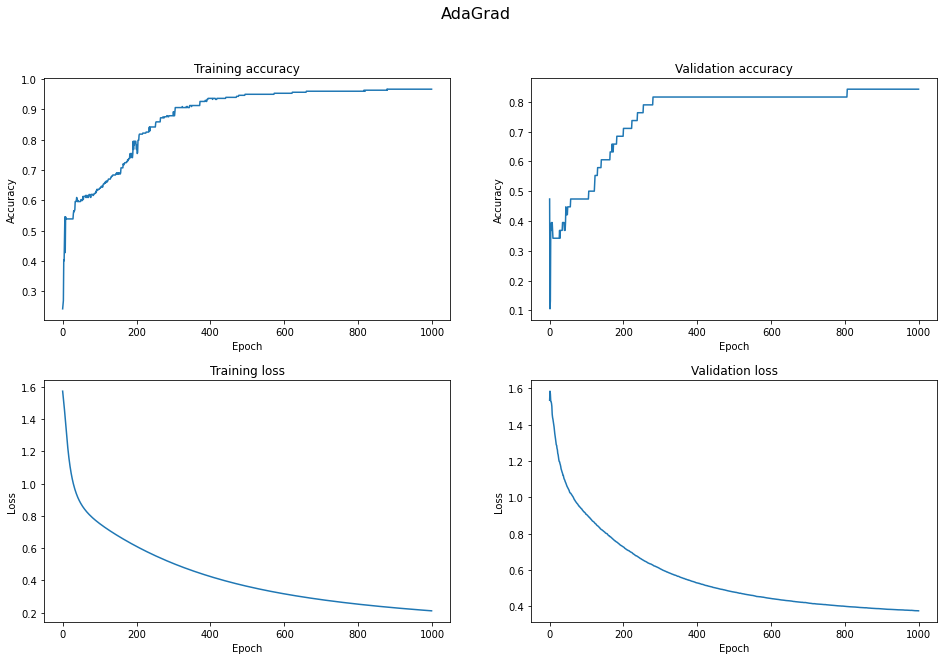

In [5]:
out_history=[]
all_w=[]
eta=0.02
model2 = NN_model([
            One_layer(in_dim=train_data.shape[0],out_dim=32,act="sigmoid",lr=eta,apt_type='AdaGrad',val=0.2),
            One_layer(in_dim=32,out_dim=5,act="softmax",lr=eta,apt_type='AdaGrad',val=0.1)],
            batch_size = 4,loss='Multi_class'
    ) 
history,all_w = model2.training(train_data,valid_data,train_label,valid_label,epochs=1000)
out_history.append(history)

def draw(hh,title):
    fig = plt.figure(figsize=(16,10))
    fig.subplots_adjust(hspace=0.25, wspace=0.2)
    plt.subplot(2,2,1)
    for i,h in enumerate(hh):
        plt.plot(h.T[2])
    plt.title('Training accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')

    plt.subplot(2,2,2)
    for i,h in enumerate(hh):
        plt.plot(h.T[3])
    plt.title('Validation accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.subplot(2,2,3)
    for i,h in enumerate(hh):
        plt.plot(h.T[0])
    plt.title('Training loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')

    plt.subplot(2,2,4)
    for i,h in enumerate(hh):
        plt.plot(h.T[1])
    plt.title('Validation loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')

    fig.suptitle(title, fontsize=16)
    plt.show()
draw(out_history,"AdaGrad")

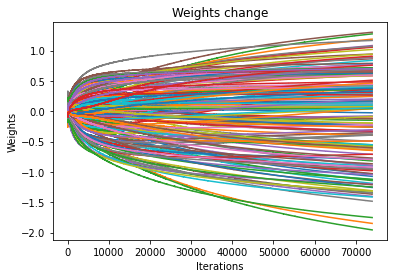

In [6]:
plt.title('Weights change')
plt.ylabel('Weights')
plt.xlabel('Iterations')
plt.plot(np.array(all_w).reshape((len(all_w),all_w[0].shape[0]*all_w[0].shape[1])))
plt.show()

Epoch 0 / 1000 - loss: 1.5621 - accuracy: 0.2761 - val_loss: 1.5750 - val_accuracy: 0.2895
Epoch 1 / 1000 - loss: 1.5409 - accuracy: 0.4007 - val_loss: 1.5706 - val_accuracy: 0.2368
Epoch 2 / 1000 - loss: 1.5222 - accuracy: 0.4007 - val_loss: 1.5612 - val_accuracy: 0.2368
Epoch 3 / 1000 - loss: 1.5065 - accuracy: 0.4175 - val_loss: 1.5511 - val_accuracy: 0.2632
Epoch 4 / 1000 - loss: 1.4919 - accuracy: 0.4175 - val_loss: 1.5409 - val_accuracy: 0.2632
Epoch 5 / 1000 - loss: 1.4777 - accuracy: 0.5118 - val_loss: 1.5326 - val_accuracy: 0.3158
Epoch 6 / 1000 - loss: 1.4636 - accuracy: 0.5118 - val_loss: 1.5251 - val_accuracy: 0.3158
Epoch 7 / 1000 - loss: 1.4501 - accuracy: 0.5118 - val_loss: 1.5166 - val_accuracy: 0.3158
Epoch 8 / 1000 - loss: 1.4372 - accuracy: 0.5118 - val_loss: 1.5106 - val_accuracy: 0.3158
Epoch 9 / 1000 - loss: 1.4250 - accuracy: 0.5387 - val_loss: 1.5019 - val_accuracy: 0.3421
Epoch 10 / 1000 - loss: 1.4130 - accuracy: 0.5387 - val_loss: 1.4936 - val_accuracy: 0.342

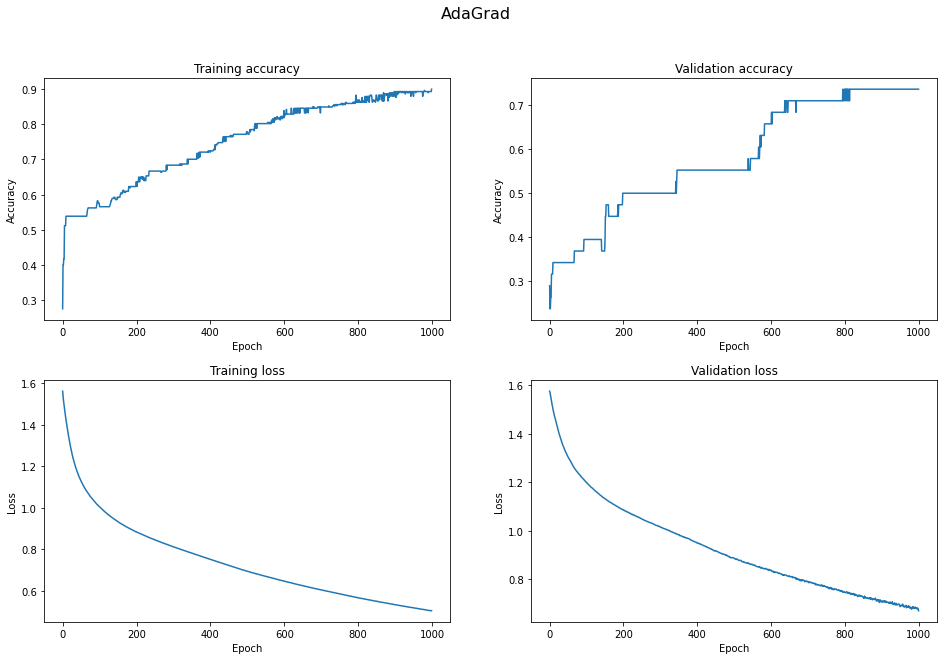

In [7]:
out_history=[]
all_w=[]
eta=0.004
model3 = NN_model([
            RBF_layer(in_dim=train_data.shape[0], out_dim=32 , cent_lr = eta, wid_lr=eta,data =train_data.T,act= "gaussian"),
            One_layer(in_dim=32,out_dim=5,act="softmax",lr=eta,apt_type='AdaGrad',val=0.2)],
            batch_size = 8,loss='Multi_class'
    ) 
history,all_w = model3.training(train_data,valid_data,train_label,valid_label,epochs=1000)
out_history.append(history)

def draw(hh,title):
    fig = plt.figure(figsize=(16,10))
    fig.subplots_adjust(hspace=0.25, wspace=0.2)
    plt.subplot(2,2,1)
    for i,h in enumerate(hh):
        plt.plot(h.T[2])
    plt.title('Training accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')

    plt.subplot(2,2,2)
    for i,h in enumerate(hh):
        plt.plot(h.T[3])
    plt.title('Validation accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.subplot(2,2,3)
    for i,h in enumerate(hh):
        plt.plot(h.T[0])
    plt.title('Training loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')

    plt.subplot(2,2,4)
    for i,h in enumerate(hh):
        plt.plot(h.T[1])
    plt.title('Validation loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')

    fig.suptitle(title, fontsize=16)
    plt.show()
draw(out_history,"AdaGrad")

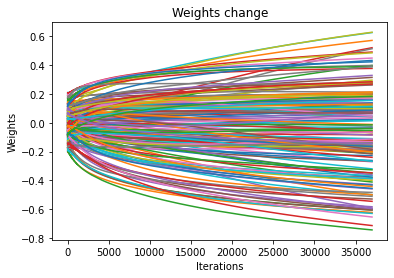

In [8]:
plt.title('Weights change')
plt.ylabel('Weights')
plt.xlabel('Iterations')
plt.plot(np.array(all_w).reshape((len(all_w),all_w[0].shape[0]*all_w[0].shape[1])))
plt.show()